In [2]:
#lets download important library to set up a connection with MYSQL
!pip install mysqlclient

In [1]:
#import the required libraries
import MySQLdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
import re
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Loading the sql file ibn the database
def exec_sql_file(cursor, sql_file):
    print ("\n[INFO] Executing SQL script file: '%s'" % (sql_file))
    statement = ""

    for line in open(sql_file):
        if re.match(r'--', line):  # ignore sql comment lines
            continue
        if not re.search(r'[^-;]+;', line):  # keep appending lines that don't end in ';'
            statement = statement + line
        else:  # when you get a line ending in ';' then exec statement and reset for next statement
            statement = statement + line
            #print "\n\n[DEBUG] Executing SQL statement:\n%s" % (statement)
            try:
                cursor.execute(statement)
            except (OperationalError, ProgrammingError) as e:
                print ("\n[WARN] MySQLError during execute statement \n\tArgs: '%s'" % (str(e.args)))

            statement = ""
# Let's Create the database using the given SQL File            
sql_file="D:/technical.sql/technical.sql"
mysql_cn= MySQLdb.connect(host='localhost', port=3306,user='root', passwd='Root@123', db='technical_db')
cursor=mysql_cn.cursor()
exec_sql_file(cursor, sql_file)
mysql_cn.close()            


[INFO] Executing SQL script file: 'D:/technical.sql/technical.sql'


In [8]:
mysql_cn= MySQLdb.connect(host='localhost', 
                port=3306,user='root', passwd='Root@123', 
                db='technical_db')
unique_isin = pd.read_sql('''SELECT DISTINCT(isin) FROM technical_minute; ''', con=mysql_cn)    
print ('Loaded all the unique isis present in database:\n\n',unique_isin)
mysql_cn.close()

Loaded all the unique isis present in database:

             isin
0      dummy1611
1      dummy3751
2      dummy3811
3   INE180A01020
4   INE195A01028
5   INE221B01012
6   INE265F01028
7   INE271B01025
8   INE298G01027
9   INE397D01024
10  INE436A01026
11  INE451F01016
12  INE492A01029
13  INE545A01016
14  INE885E01034
15  INE916G01016


In [11]:
#Now set up a connection with the database and load our data
#Here I have loaded only a small part of data as resources like RAM were not available
#I have selected the company "INE545A01016" same code cane run for all other companies by changing below
mysql_cn= MySQLdb.connect(host='localhost', 
                port=3306,user='root', passwd='Root@123', 
                db='technical_db')
df_mysql = pd.read_sql('''SELECT * FROM technical_minute WHERE isin='INE545A01016' ORDER BY datetime ASC; ''', con=mysql_cn)    
print ('loaded dataframe from MySQL\n',df_mysql.head())
mysql_cn.close()

loaded dataframe from MySQL
            isin insertion_datetime            datetime    open    high  \
0  INE545A01016                NaT 2017-04-03 09:15:00  223.45  223.45   
1  INE545A01016                NaT 2017-04-03 09:16:00  223.45  223.45   
2  INE545A01016                NaT 2017-04-03 09:17:00  223.45  223.45   
3  INE545A01016                NaT 2017-04-03 09:18:00  223.45  223.45   
4  INE545A01016                NaT 2017-04-03 09:19:00  223.45  223.45   

      low   close  volume  open_interest  
0  223.45  223.45      20            NaN  
1  223.45  223.45       0            NaN  
2  223.45  223.45       0            NaN  
3  223.45  223.45       0            NaN  
4  223.45  223.45     100            NaN  


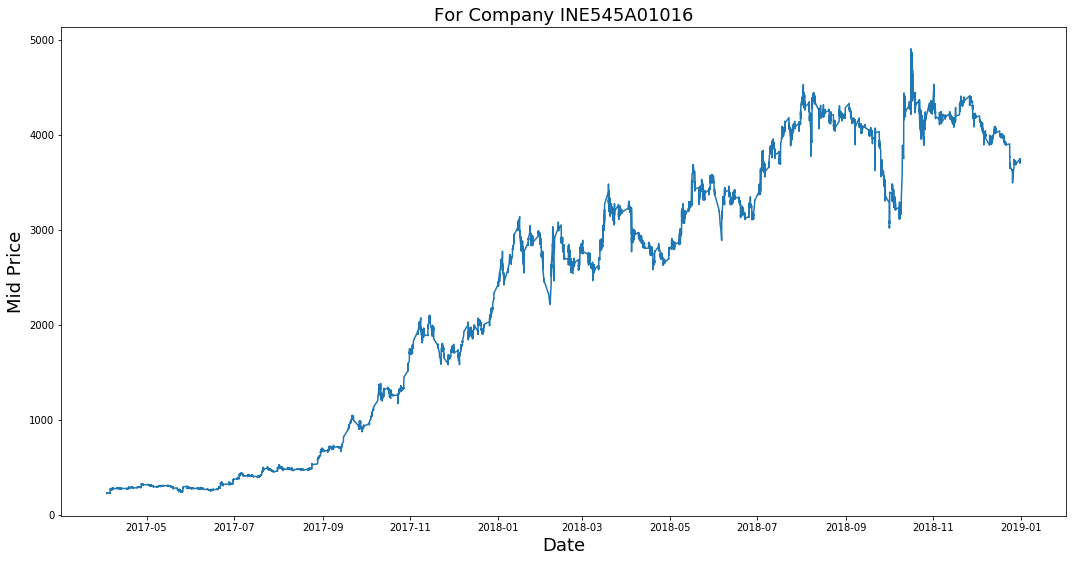

In [12]:
plt.figure(figsize = (18,9))
plt.plot(df_mysql.datetime,(df_mysql.low+df_mysql.high)/2.0)
plt.title('For Company INE545A01016',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [13]:
# dividing data in train and test set in the 50-50 manner
high_prices = np.array(df_mysql.high)
low_prices = np.array(df_mysql.low)
mid_prices = (high_prices+low_prices)/2.0
train_data = mid_prices[:80000];print("Trainning Data Shape: ",train_data.shape)
test_data = mid_prices[80000:];print("Test Data Shape: ",test_data.shape)

Trainning Data Shape:  (80000,)
Test Data Shape:  (81138,)


In [14]:
#Normalize the data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)
smoothing_window_size =15000
for di in range(0,70000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)


In [15]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(80000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA
# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [16]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df_mysql.datetime

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)
print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00064


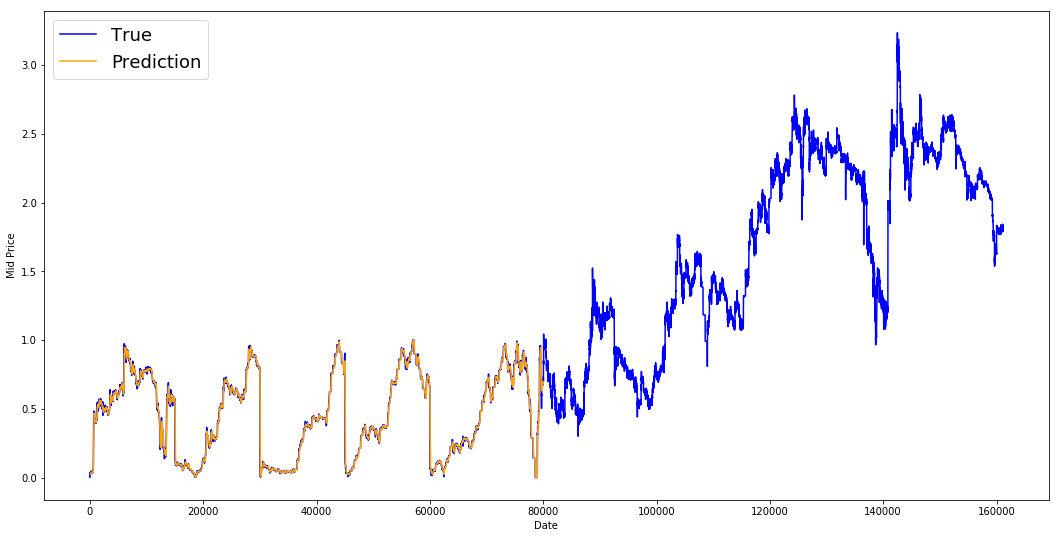

In [17]:
plt.figure(figsize = (18,9))
plt.plot(range(train_data.size+test_data.size),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

MSE error for EMA averaging: 0.00000


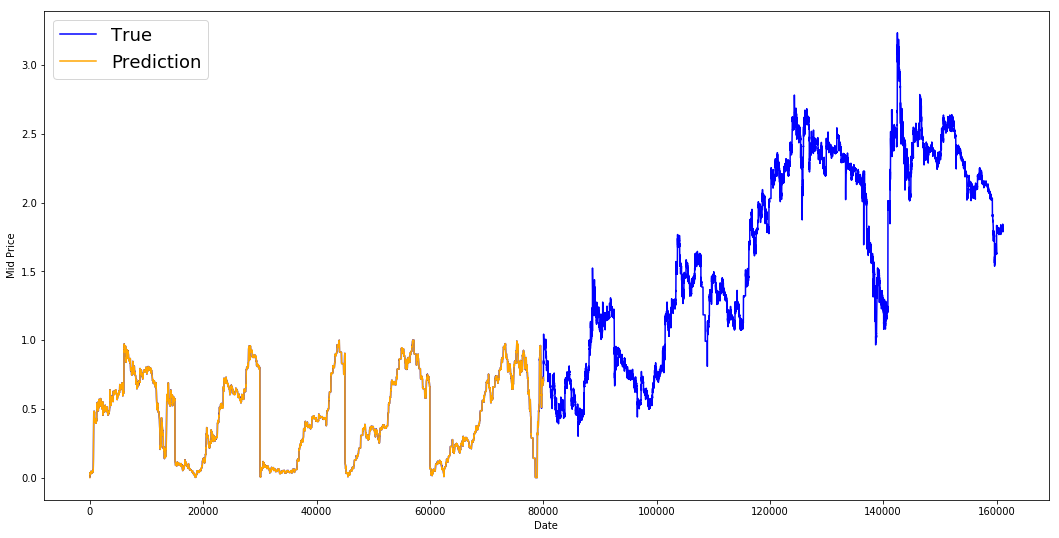

In [18]:
# Here we will demonstrate the exponential moving avereage and show it can easily fit the data more accurately
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


plt.figure(figsize = (18,9))
plt.plot(range(train_data.size+test_data.size),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()